## Imports

In [161]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
import joblib

import tensorflow as tf
import re
import random
import tf_keras
from tf_keras.callbacks import EarlyStopping  # Use tf.keras.callbacks
import kagglehub
import zipfile
import shutil

## Downloading the Data

In [162]:
def download_and_extract_data(filename="output_latest", filename_output="output"):
    """
    Downloads, extracts, and deletes a zip file if it doesn't already exist.

    Args:
        filename: The name of the zip file to download.
        filename_output: The name of the folder to extract the contents to.
    """
    if not os.path.exists(filename_output):
        try:
            # Download the .zip file
            print(f"Downloading '{filename}'...")
            # Get the actual downloaded file path
            downloaded_file_path = kagglehub.dataset_download("sulimantadros/trend-identification-dataset")

            # Rename if necessary (if kagglehub returns a different name)
            if downloaded_file_path != filename:
                os.rename(downloaded_file_path, filename)
                print(f"Renamed downloaded file to '{filename}'")

        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print(f"File '{filename_output}' already exists. Skipping download and extraction.")

download_and_extract_data(filename="output_latest.zip", filename_output="output")

100%|██████████| 37.9M/37.9M [00:02<00:00, 13.5MB/s]

Extracting files...


An error occurred: [Errno 39] Directory not empty: '/root/.cache/kagglehub/datasets/sulimantadros/trend-identification-dataset/versions/1' -> 'output_latest.zip'


## Exploring the data

In [163]:
import os

def get_image_paths():
  # Define the folder paths
  train_folder_bullish = '/content/output_latest.zip/output/train/bullish'
  train_folder_bearish = '/content/output_latest.zip/output/train/bearish'
  train_folder_sideways = '/content/output_latest.zip/output/train/sideways'
  test_folder_bullish = '/content/output_latest.zip/output/test/bullish'
  test_folder_bearish = '/content/output_latest.zip/output/test/bearish'
  test_folder_sideways = '/content/output_latest.zip/output/test/sideways'

  # Create a dictionary to store the file paths for each folder
  file_paths = {
      'train_bullish': [],
      'train_bearish': [],
      'train_sideways': [],
      'test_bullish': [],
      'test_bearish': [],
      'test_sideways': []
  }

  # Function to populate file paths for a given folder and key
  def populate_file_paths(folder_path, key):
      for file in os.listdir(folder_path):
          file_paths[key].append(os.path.join(folder_path, file))

  # Populate file paths for each folder
  populate_file_paths(train_folder_bullish, 'train_bullish')
  populate_file_paths(train_folder_bearish, 'train_bearish')
  populate_file_paths(train_folder_sideways, 'train_sideways')
  populate_file_paths(test_folder_bullish, 'test_bullish')
  populate_file_paths(test_folder_bearish, 'test_bearish')
  populate_file_paths(test_folder_sideways, 'test_sideways')

  # Access the file paths using the dictionary keys
  print(f"Train bullish file paths: {file_paths['train_bullish'][:5]}")
  print(f"Train bearish file paths: {file_paths['train_bearish'][:5]}")
  print(f"Train sideways file paths: {file_paths['train_sideways'][:5]}")
  print(f"Test bullish file paths: {file_paths['test_bullish'][:5]}")
  print(f"Test bearish file paths: {file_paths['test_bearish'][:5]}")
  print(f"Test sideways file paths: {file_paths['test_sideways'][:5]}")

  return file_paths


In [164]:
file_paths = get_image_paths()

Train bullish file paths: ['/content/output_latest.zip/output/train/bullish/NZDUSD_202104050826.png', '/content/output_latest.zip/output/train/bullish/GBPUSD_202404230758.png', '/content/output_latest.zip/output/train/bullish/NZDUSD_202112210826.png', '/content/output_latest.zip/output/train/bullish/GBPUSD_202006300758.png', '/content/output_latest.zip/output/train/bullish/USDCAD_202111252019.png']
Train bearish file paths: ['/content/output_latest.zip/output/train/bearish/USDJPY_202301021952.png', '/content/output_latest.zip/output/train/bearish/EURUSD_202309270746.png', '/content/output_latest.zip/output/train/bearish/AUDUSD_202411052012.png', '/content/output_latest.zip/output/train/bearish/USDCAD_202210170819.png', '/content/output_latest.zip/output/train/bearish/NZDUSD_202101080826.png']
Train sideways file paths: ['/content/output_latest.zip/output/train/sideways/USDJPY_202101261952.png', '/content/output_latest.zip/output/train/sideways/EURUSD_202203160746.png', '/content/output

In [165]:
def show_random_image(folder_key=None, file_path=None):
    """
    Displays an image from a specific file path, or a random image from the specified folder key.
    If folder_key is None, a random folder key is chosen. If file_path is provided, it overrides
    folder_key and directly visualizes the specified image.

    Args:
        folder_key: The key of the folder to get the image from
                    (e.g., 'train_bullish', 'test_sideways').
                    If None, a random folder key is chosen.
        file_path: The full file path to an image. If provided, this overrides folder_key.

    Returns:
        The path of the displayed image.
    """
    # List of all possible folder keys
    possible_folder_keys = [
        'train_bullish', 'train_bearish', 'train_sideways',
        'test_bullish', 'test_bearish', 'test_sideways'
    ]

    # If a file path is provided, display that image
    if file_path:
        if os.path.exists(file_path):
            print(f"Displaying image from specified file path: {file_path}")
            plt.figure(figsize=(5, 5))
            img = mpimg.imread(file_path)
            plt.imshow(img)
            plt.title("Specified Image")
            plt.axis('off')
            plt.show()
            return file_path
        else:
            print(f"File path does not exist: {file_path}")
            return None

    # Choose a random folder key if not provided
    if folder_key is None:
        folder_key = random.choice(possible_folder_keys)
        print(f"No folder key provided. Randomly selected folder key: {folder_key}")

    # Check if the folder key is valid
    if folder_key not in file_paths:
        print(f"Invalid folder key: {folder_key}")
        return None

    # Check if there are images in the selected folder
    if not file_paths[folder_key]:
        print(f"No images found in folder key: {folder_key}")
        return None

    # Choose a random image from the specified folder
    image_path = random.choice(file_paths[folder_key])

    # Display the image
    plt.figure(figsize=(5, 5))
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(f"Random Image from {folder_key}")
    plt.axis('off')
    plt.show()

    return image_path

Displaying image from specified file path: /content/output_latest.zip/output/train/bullish/NZDUSD_202104050826.png


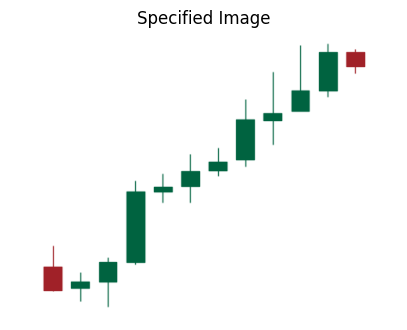

'/content/output_latest.zip/output/train/bullish/NZDUSD_202104050826.png'

In [166]:
show_random_image(file_path='/content/output_latest.zip/output/train/bullish/NZDUSD_202104050826.png')

## Manipulating the data (Getting it ready for a machine learning model)

In [167]:
# Create constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_dir = '/content/output_latest.zip/output/train'
test_dir = '/content/output_latest.zip/output/test'

# Directories
original_train_dir = train_dir  # Path to original training data
balanced_train_dir = "balanced_train_dir"  # Temporary directory for balanced data

# Get class distributions
class_counts = {cls: len(os.listdir(os.path.join(original_train_dir, cls))) for cls in os.listdir(original_train_dir)}
print("Class distribution:", class_counts)

# Find the minimum number of samples (for the minority class)
min_samples = min(class_counts.values())

# Undersample the majority class
if not os.path.exists(balanced_train_dir):
    os.makedirs(balanced_train_dir)

for cls in os.listdir(original_train_dir):
    class_dir = os.path.join(original_train_dir, cls)
    balanced_class_dir = os.path.join(balanced_train_dir, cls)

    if not os.path.exists(balanced_class_dir):
        os.makedirs(balanced_class_dir)

    # Get all image file paths
    all_images = os.listdir(class_dir)
    random.shuffle(all_images)

    # Copy only min_samples images to the balanced directory
    for img in all_images[:min_samples]:
        shutil.copy(os.path.join(class_dir, img), os.path.join(balanced_class_dir, img))

# Create a balanced train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=balanced_train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

# Use your test dataset as it is
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

Class distribution: {'bearish': 1074, 'sideways': 10809, 'bullish': 1080}
Found 4097 files belonging to 3 classes.
Found 3359 files belonging to 3 classes.


In [168]:
len(train_ds), len(test_ds)

(129, 105)

In [169]:
class_names = train_ds.class_names
class_names

['bearish', 'bullish', 'sideways']

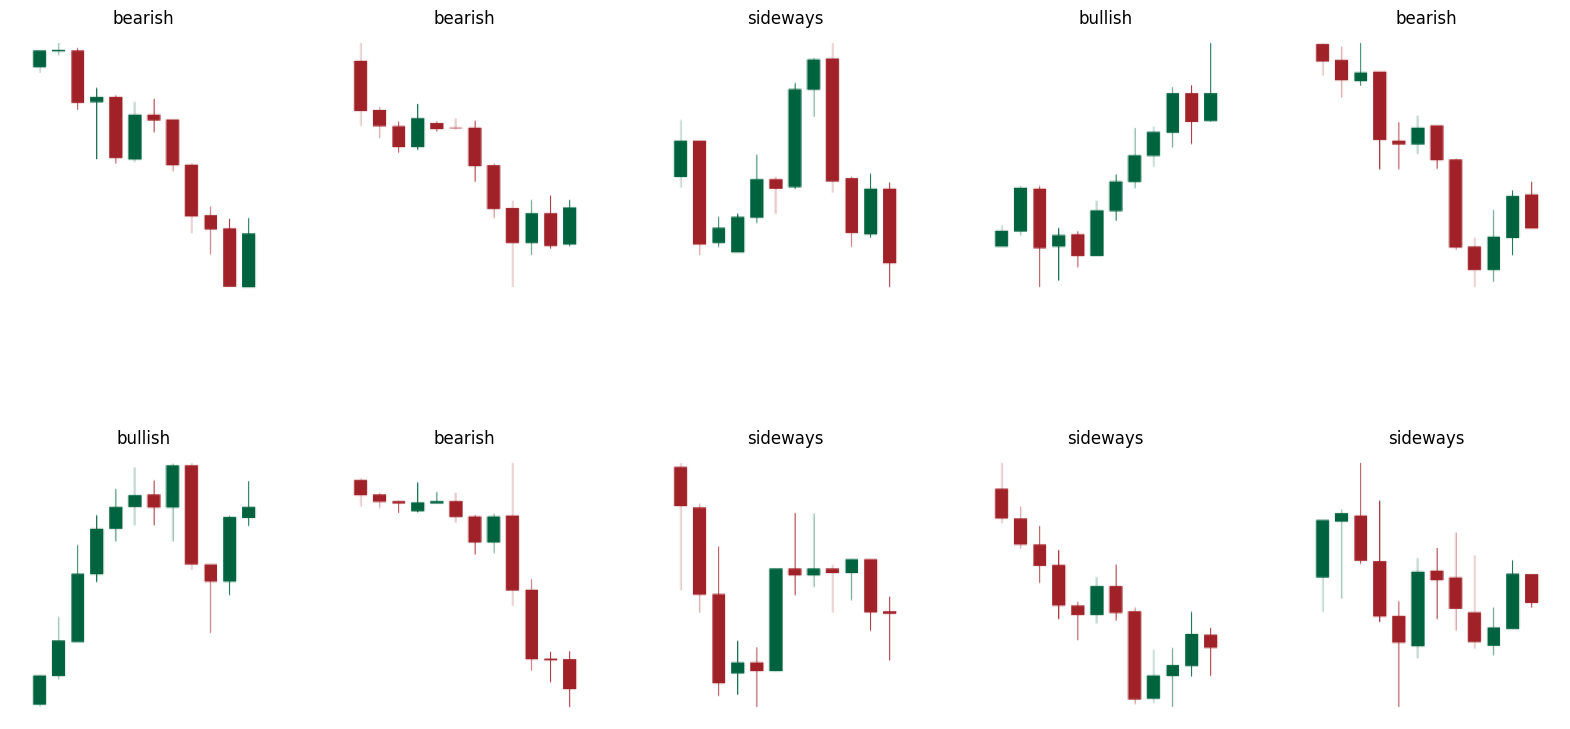

In [170]:
# Create multiple subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# Iterate through a single batch and plot images
for images, labels in train_ds.take(count=1):
  for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].numpy().astype("uint8"))

    # Get the label for the current image
    label = labels[i].numpy()
    label_str = class_names[np.argmax(label)]

    ax.set_title(label_str)
    ax.axis("off")

plt.show()

In [171]:
AUTOTUNE = tf.data.AUTOTUNE # let TensorFlow find the best values to use automatically

# Shuffle and optimize performance on training datasets
# Note: these methods can be chained together and will have the same effect as calling them individually
train_ds = train_ds.cache().shuffle(buffer_size=100*BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Don't need to shuffle test datasets (for easier evaluation)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Building a machine learning model

In [172]:
def count_parameters(model, print_output=True):
  """
  Counts the number of trainable, non-trainable and total parameters of a given model.
  """
  trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.trainable_weights])
  non_trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.non_trainable_weights])
  total_parameters = trainable_parameters + non_trainable_parameters
  if print_output:
    print(f"Model {model.name} parameter counts:")
    print(f"Total parameters: {total_parameters}")
    print(f"Trainable parameters: {trainable_parameters}")
    print(f"Non-trainable parameters: {non_trainable_parameters}")
  else:
    return total_parameters, trainable_parameters, non_trainable_parameters

In [173]:
def create_model(include_top: bool = False,
                 num_classes: int = 1000,
                 input_shape: tuple[int, int, int] = (224, 224, 3),
                 include_preprocessing: bool = True,
                 trainable: bool = False,
                 dropout: float = 0.2,
                 activation: str = "softmax",
                 model_name: str = "model") -> tf_keras.Model:
  """
  Create an EfficientNetV2 B0 feature extractor model with a custom classifier layer.

  Args:
      include_top (bool, optional): Whether to include the top (classifier) layers of the model.
      num_classes (int, optional): Number of output classes for the classifier layer.
      input_shape (tuple[int, int, int], optional): Input shape for the model's images (height, width, channels).
      include_preprocessing (bool, optional): Whether to include preprocessing layers for image normalization.
      trainable (bool, optional): Whether to make the base model trainable.
      dropout (float, optional): Dropout rate for the global average pooling layer.
      model_name (str, optional): Name for the created model.

  Returns:
      tf.keras.Model: A TensorFlow Keras model with the specified configuration.
  """
  # Create base model
  base_model = tf_keras.applications.ConvNeXtXLarge(
    include_top=include_top,
    weights="imagenet",
    input_shape=input_shape,
    include_preprocessing=include_preprocessing,
    # pooling="avg" # Can use this instead of adding tf.keras.layers.GlobalPooling2D() to the model
    pooling="max" # Can use this instead of adding tf.keras.layers.MaxPooling2D() to the model
  )

  # Freeze the base model (if necessary)
  base_model.trainable = trainable

  # Create input layer
  inputs = tf_keras.Input(shape=input_shape, name="input_layer")

  # Create model backbone (middle/hidden layers)
  x = base_model(inputs, training=trainable)

  # Create output layer (also known as "classifier" layer)
  outputs = tf_keras.layers.Dense(units=num_classes,
                                  activation=activation,
                                  name="output_layer")(x)

  # Connect input and output layer
  model = tf_keras.Model(inputs=inputs,
                         outputs=outputs,
                         name=model_name)

  return model

## Training model 0

In [174]:
# 1. Create a model
model_0 = create_model(num_classes=len(class_names), trainable=False)

count_parameters(model=model_0, print_output=True)

# 2. Compile the model
model_0.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.001),
                loss=tf_keras.losses.CategoricalCrossentropy(from_logits=False),  # use from_logits=False if using an activation function in final layer
                metrics=["accuracy"])

# Define the EarlyStopping callback
early_stopping = tf_keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor for early stopping
    patience=5,              # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# 3. Fit the model
epochs = 1000
history_0 = model_0.fit(
    x=train_ds,
    epochs=epochs,
    validation_data=test_ds,
    callbacks=[early_stopping]
)

# 4. Save the model
import os

save_dir = "saved_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)  # Create directory if it doesn't exist

model_save_path = os.path.join(save_dir, "model_0.keras")
model_0.save(model_save_path)

print(f"Model saved to: {model_save_path}")


Model model parameter counts:
Total parameters: 348154115
Trainable parameters: 6147
Non-trainable parameters: 348147968
Epoch 1/1000
129/129 [==============================] - 166s 1s/step - loss: 0.6742 - accuracy: 0.7340 - val_loss: 0.3850 - val_accuracy: 0.8503
Epoch 2/1000
129/129 [==============================] - 133s 1s/step - loss: 0.4536 - accuracy: 0.8182 - val_loss: 0.4020 - val_accuracy: 0.8386
Epoch 3/1000
129/129 [==============================] - 133s 1s/step - loss: 0.4206 - accuracy: 0.8301 - val_loss: 0.4920 - val_accuracy: 0.7937
Epoch 4/1000
129/129 [==============================] - 133s 1s/step - loss: 0.3904 - accuracy: 0.8365 - val_loss: 0.3677 - val_accuracy: 0.8422
Epoch 5/1000
129/129 [==============================] - 133s 1s/step - loss: 0.3639 - accuracy: 0.8587 - val_loss: 0.5091 - val_accuracy: 0.7913
Epoch 6/1000
129/129 [==============================] - 134s 1s/step - loss: 0.3476 - accuracy: 0.8570 - val_loss: 0.3272 - val_accuracy: 0.8622
Epoch 7/1

## Evaluate Model

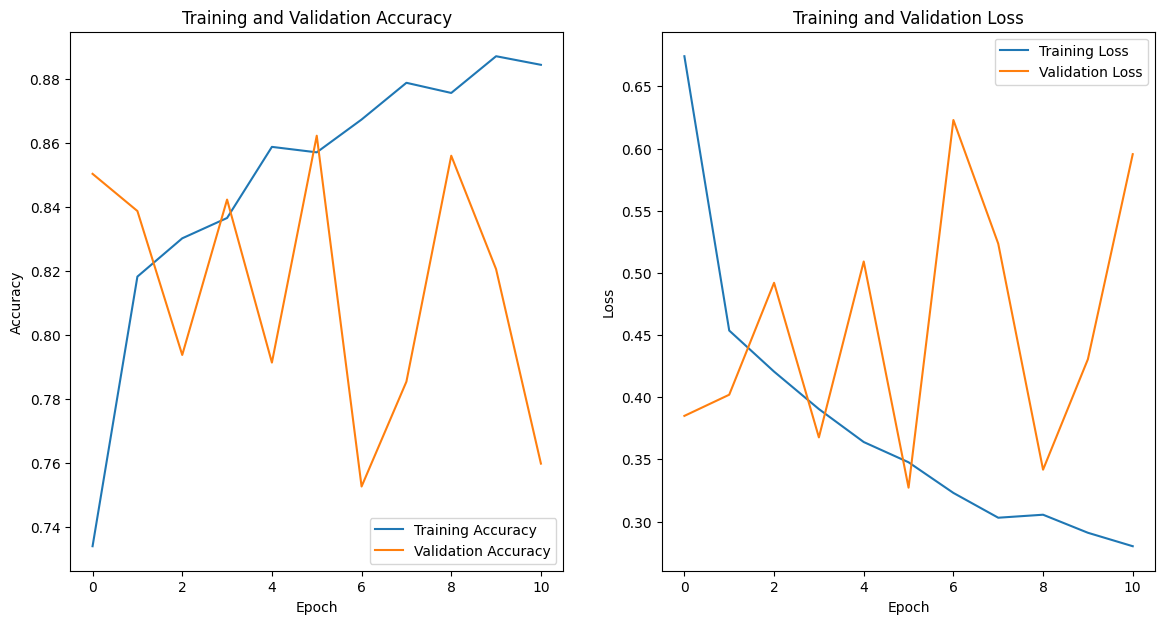

In [175]:
def plot_model_loss_curves(history: tf.keras.callbacks.History) -> None:
  """Takes a History object and plots loss and accuracy curves."""

  # Get the accuracy values
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  # Get the loss values
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  # Get the number of epochs
  epochs_range = range(len(acc))

  # Create accuracy curves plot
  plt.figure(figsize=(14, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label="Training Accuracy")
  plt.plot(epochs_range, val_acc, label="Validation Accuracy")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")

  # Create loss curves plot
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label="Training Loss")
  plt.plot(epochs_range, val_loss, label="Validation Loss")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.show()

plot_model_loss_curves(history=history_0)

In [176]:
model_0_results = model_0.evaluate(x=test_ds)
model_0_results

105/105 [==============================] - 60s 573ms/step - loss: 0.3272 - accuracy: 0.8622


[0.32723426818847656, 0.8621613383293152]

In [177]:
# Get our model's metrics names
model_0.metrics_names

['loss', 'accuracy']

In [178]:
# This will output logits (as long as softmax activation isn't in the model)
test_preds = model_0.predict(test_ds)

105/105 [==============================] - 63s 569ms/step


In [179]:
test_preds.shape

(3359, 3)

In [180]:
# Get a "random" variable between all of the test samples
random.seed(42)
random_test_index = random.randint(0, test_preds.shape[0] - 1)
print(f"[INFO] Random test index: {random_test_index}")

# Inspect a single test prediction sample
random_test_pred_sample = test_preds[random_test_index]

print(f"[INFO] Random test pred sample shape: {random_test_pred_sample.shape}")
print(f"[INFO] Random test pred sample argmax: {tf.argmax(random_test_pred_sample)}")
print(f"[INFO] Random test pred sample label: {class_names[tf.argmax(random_test_pred_sample)]}")
print(f"[INFO] Random test pred sample max prediction probability: {tf.reduce_max(random_test_pred_sample)}")
print(f"[INFO] Random test pred sample prediction probability values:\n{random_test_pred_sample}")

[INFO] Random test index: 2619
[INFO] Random test pred sample shape: (3,)
[INFO] Random test pred sample argmax: 2
[INFO] Random test pred sample label: sideways
[INFO] Random test pred sample max prediction probability: 0.9983141422271729
[INFO] Random test pred sample prediction probability values:
[1.4189350e-03 2.6689883e-04 9.9831414e-01]


In [181]:
import numpy as np

# Extract test images and labels from test_ds
test_ds_images = np.concatenate([images for images, labels in test_ds], axis=0)
test_ds_labels = np.concatenate([labels for images, labels in test_ds], axis=0)

# How many images and labels do we have?
len(test_ds_images), len(test_ds_labels)

(3359, 3359)

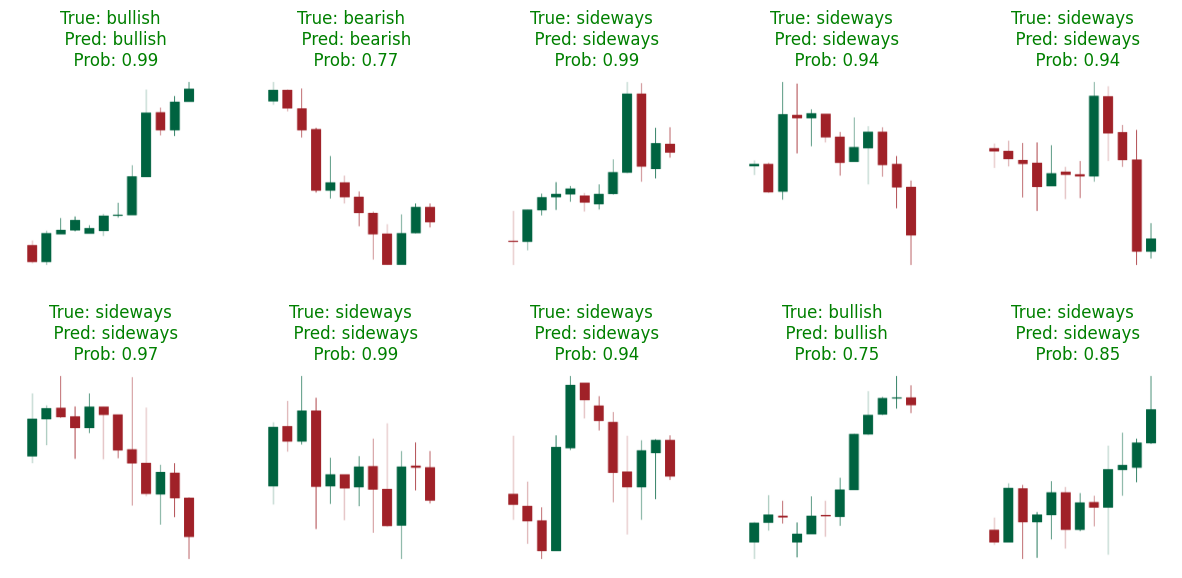

In [182]:
# Choose a random 10 indexes from the test data and compare the values
import random

#random.seed(42) # try changing the random seed or commenting it out for different values
random_indexes = random.sample(range(len(test_ds_images)), 10)

# Create a plot with multiple subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

# Loop through the axes of the plot
for i, ax in enumerate(axes.flatten()):
  target_index = random_indexes[i] # get a random index (this is another reason we didn't shuffle the test set)

  # Get relevant target image, label, prediction and prediction probabilities
  test_image = test_ds_images[target_index]
  test_image_truth_label = class_names[tf.argmax(test_ds_labels[target_index])]
  test_image_pred_probs = test_preds[target_index]
  test_image_pred_class = class_names[tf.argmax(test_image_pred_probs)]

  # Plot the image
  ax.imshow(test_image.astype("uint8"))

  # Create sample title
  title = f"""True: {test_image_truth_label}
  Pred: {test_image_pred_class}
  Prob: {np.max(test_image_pred_probs):.2f}"""

  # Colour the title based on correctness of pred
  ax.set_title(title,
               color="green" if test_image_truth_label == test_image_pred_class else "red")
  ax.axis("off")

In [183]:
# Get argmax labels of test predictions and test ground truth
test_preds_labels = test_preds.argmax(axis=-1)
test_ds_labels_argmax = test_ds_labels.argmax(axis=-1)

# Get highest prediction probability of test predictions
test_pred_probs_max = tf.reduce_max(test_preds, axis=-1).numpy() # extract NumPy since pandas doesn't handle TensorFlow Tensors

# Create DataFram of test results
test_results_df = pd.DataFrame({"test_pred_label": test_preds_labels,
                                "test_pred_prob": test_pred_probs_max,
                                "test_pred_class_name": [class_names[test_pred_label] for test_pred_label in test_preds_labels],
                                "test_truth_label": test_ds_labels_argmax,
                                "test_truth_class_name": [class_names[test_truth_label] for test_truth_label in test_ds_labels_argmax]})

# Create a column whether or not the prediction matches the label
test_results_df["correct"] = test_results_df["test_pred_class_name"] == test_results_df["test_truth_class_name"]

test_results_df.head()

,test_pred_label,test_pred_prob,test_pred_class_name,test_truth_label,test_truth_class_name,correct
0,0,0.598778,bearish,0,bearish,True
1,2,0.987088,sideways,0,bearish,False
2,2,0.921287,sideways,0,bearish,False
3,2,0.839277,sideways,0,bearish,False
4,2,0.540050,sideways,0,bearish,False


In [184]:
# Calculate accuracy per class
accuracy_per_class = test_results_df.groupby("test_truth_class_name")["correct"].mean()

# Create new DataFrame to sort classes by accuracy
accuracy_per_class_df = pd.DataFrame(accuracy_per_class).reset_index().sort_values("correct", ascending=False)
accuracy_per_class_df.head()

,test_truth_class_name,correct
2,sideways,0.906217
0,bearish,0.714789
1,bullish,0.546154


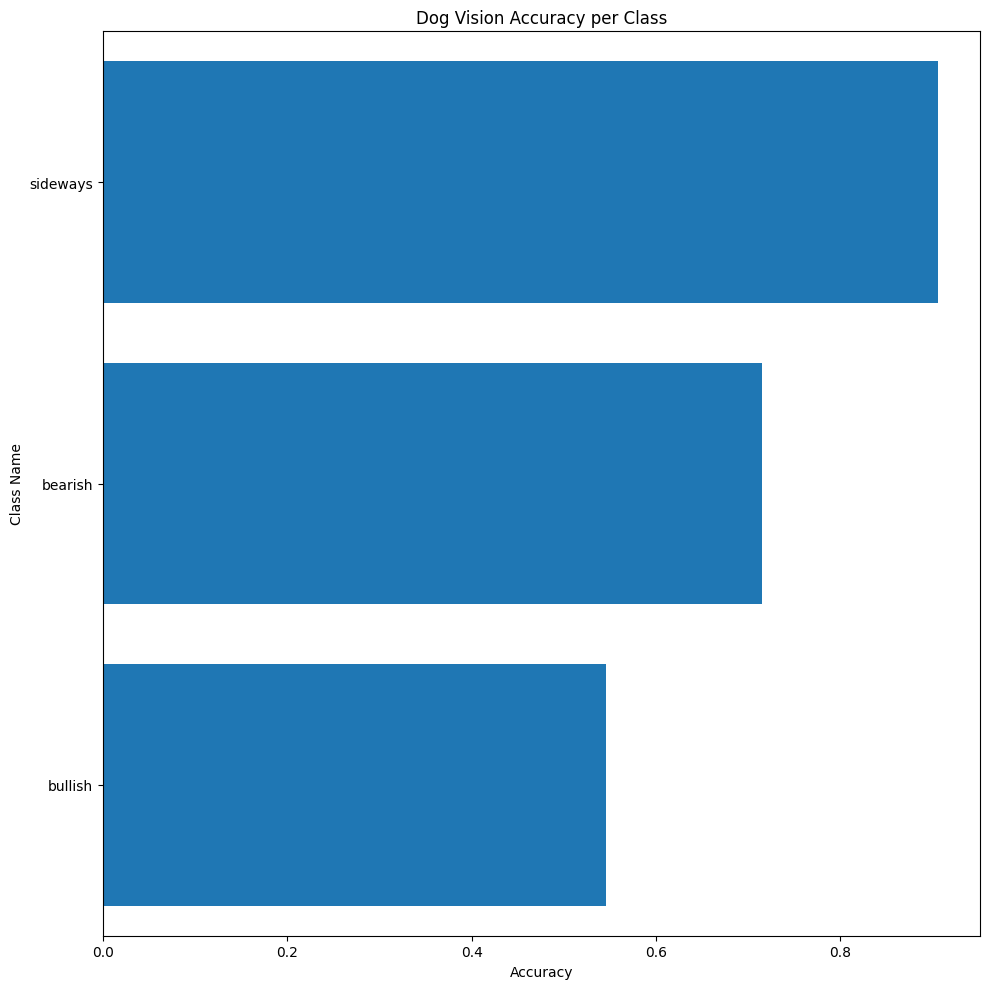

In [185]:
# Let's create a horizontal bar chart to replicate a similar plot to the original Stanford Dogs page
plt.figure(figsize=(10, 10))
plt.barh(y=accuracy_per_class_df["test_truth_class_name"],
         width=accuracy_per_class_df["correct"])
plt.xlabel("Accuracy")
plt.ylabel("Class Name")
plt.title("Dog Vision Accuracy per Class")
plt.ylim(-0.5, len(accuracy_per_class_df["test_truth_class_name"]) - 0.5)  # Adjust y-axis limits to reduce white space
plt.gca().invert_yaxis()  # This will display the first class at the top
plt.tight_layout()
plt.show()

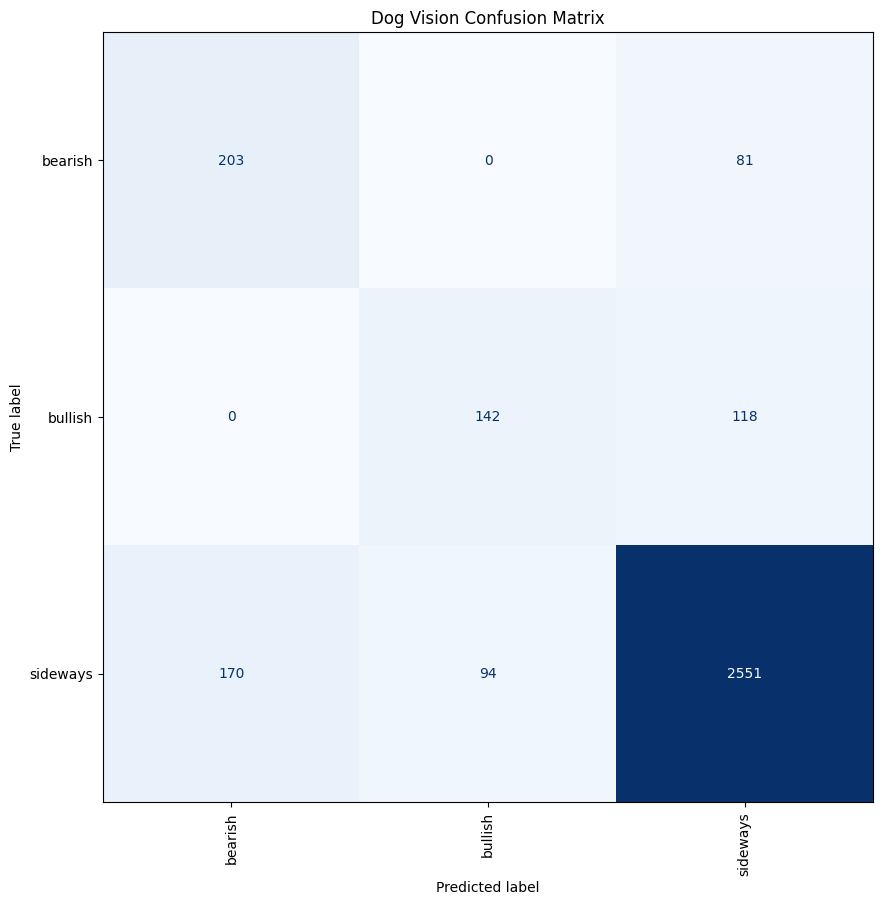

In [186]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a confusion matrix
confusion_matrix_dog_preds = confusion_matrix(y_true=test_ds_labels_argmax, # requires all labels to be in same format (e.g. not one-hot)
                                              y_pred=test_preds_labels)
# Create a confusion matrix plot
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dog_preds,
                                                  display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Dog Vision Confusion Matrix")
confusion_matrix_display.plot(xticks_rotation="vertical",
                              cmap="Blues",
                              colorbar=False,
                              ax=ax);

## Make Predictions/ load trained model